<a href="https://colab.research.google.com/github/Stepka/Mark-Guesser-Text-Semantic-Extraction-using-Gloves-and-seq2seq-with-attention/blob/master/Mark_Guesser_(Text_Semantic_Extraction_using_Gloves_and_seq2seq_with_attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Playground
# This notebook is playground for text semantic extraction task and then guess the mark based on extracted semantic.
# As input model have sentences with answer gived by person 
# and as output model should guess the mark from 0 to 5 (continious)
# that evaluate that answer. For training data marks evaluated by experts.
# 
# Model is a modification to https://github.com/dongjun-Lee/text-summarization-tensorflow by https://github.com/dongjun-Lee and tutorial by https://github.com/theamrzaki
# Model makes embeding using Gloves and then use seq2seq with attention for mark prediction

In [1]:
!pip install gensim
!pip install wget
  
import nltk
nltk.download('punkt')

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# load tqdm
!pip install https://github.com/chengs/tqdm/archive/colab.zip

     / 491kB 1.3MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wweez1f/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm


In [0]:
from nltk.tokenize import word_tokenize
import re
import collections
import pickle
import numpy as np
import pandas as pd
import math
from gensim.models.keyedvectors import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#default path for the folder inside google drive
default_path = "/content/drive/My Drive/Colab Notebooks/Text Summarization/"
#path for training text (article)
train_article_path = default_path + "Summarization Data/train/train.article.txt"  
#path for training text output (headline)
train_title_path   =  default_path + "Summarization Data/train/train.title.txt" 
#path for validation text (article)
valid_article_path =  default_path + "Summarization Data/train/valid.article.filter.txt"
#path for validation text output(headline)
valid_title_path   =  default_path + "Summarization Data/train/valid.title.filter.txt"
#glove dict
glove_dict_path    =  default_path + "Summarization Data/glove/model_glove_300.pkl"

!ls "{default_path}"

'Summarization Data'


In [6]:
# train_data = load_csv_dataset(default_path + "/data/siop_ml_train_participant.csv")
source_data = pd.read_csv(default_path + "Summarization Data/upwork/siop_ml_train_participant.csv")

all_data = pd.concat([source_data['open_ended_1'], source_data['E_Scale_score']], axis=1, keys=['answer', 'mark'])

all_data['mark'] = all_data['mark'].apply(lambda x: str(math.ceil(x*10)))

print("Num rows: {}\n".format(len(all_data.index)))
train_data = all_data[:900]
test_data = all_data[900:]

print("train data: ", len(train_data.index))
train_data.head()
print("test data: ", len(test_data.index))
test_data.head()


Num rows: 1088

train data:  900
test data:  188


,answer,mark
900,I would also not be willing to change my plans...,38
901,I would change my dates if it was reasonable t...,28
902,I would probably go ahead and let my coworker ...,32
903,I would verify that my vacation plans and date...,41
904,I would change my vacation if I didn't have an...,35


In [0]:
#valid_article_path = default_path + "sumdata/DUC2003/input.txt"
#valid_title_path   = default_path + "sumdata/DUC2003/task1_ref0.txt"

def clean_str(sentence):
    sentence = re.sub("[#.]+", "#", sentence)
    return sentence


def get_text_list(data_path, toy):
    with open (data_path, "r", encoding="utf-8") as f:
        if not toy:
            return [clean_str(x.strip()) for x in f.readlines()][:200000]
        else:
            return [clean_str(x.strip()) for x in f.readlines()][:50]


def build_dict(step, toy=False):
    if step == "train":
#         train_article_list = get_text_list(train_article_path, toy)
#         train_title_list = get_text_list(train_title_path, toy)
        if toy:
          train_article_list = train_data['answer'].values[:50]
          train_title_list = train_data['mark'].values[:50]
        else:
          train_article_list = train_data['answer'].values
          train_title_list = train_data['mark'].values
          
        words = list()
#         for sentence in train_article_list + train_title_list:
        for sentence in train_article_list + train_title_list:
            for word in word_tokenize(sentence):
                words.append(word)

        word_counter = collections.Counter(words).most_common()
        word_dict = dict()
        word_dict["<padding>"] = 0
        word_dict["<unk>"] = 1
        word_dict["<s>"] = 2
        word_dict["</s>"] = 3
        for word, _ in word_counter:
            word_dict[word] = len(word_dict)

        with open(default_path + "word_dict.pickle", "wb") as f:
            pickle.dump(word_dict, f)

    elif step == "valid":
        with open(default_path + "word_dict.pickle", "rb") as f:
            word_dict = pickle.load(f)

    reversed_dict = dict(zip(word_dict.values(), word_dict.keys()))

    article_max_len = 50
    summary_max_len = 15

    return word_dict, reversed_dict, article_max_len, summary_max_len


def build_dataset(step, word_dict, article_max_len, summary_max_len, toy=False):
    if step == "train":
#         article_list = get_text_list(train_article_path, toy)
#         title_list = get_text_list(train_title_path, toy)
      if toy:
        article_list = train_data['answer'].values[:50]
        title_list = train_data['mark'].values[:50]
      else:
        article_list = train_data['answer'].values
        title_list = train_data['mark'].values
        
    elif step == "valid":
#         article_list = get_text_list(valid_article_path, toy)
      if toy:
        article_list = test_data['answer'].values[:50]
      else:
        article_list = test_data['answer'].values
    else:
        raise NotImplementedError

    x = [word_tokenize(d) for d in article_list]
    x = [[word_dict.get(w, word_dict["<unk>"]) for w in d] for d in x]
    x = [d[:article_max_len] for d in x]
    x = [d + (article_max_len - len(d)) * [word_dict["<padding>"]] for d in x]
    
    if step == "valid":
        return x
    else:        
        y = [word_tokenize(d) for d in title_list]
        y = [[word_dict.get(w, word_dict["<unk>"]) for w in d] for d in y]
        y = [d[:(summary_max_len - 1)] for d in y]
        return x, y


def batch_iter(inputs, outputs, batch_size, num_epochs):
    inputs = np.array(inputs)
    outputs = np.array(outputs)

    num_batches_per_epoch = (len(inputs) - 1) // batch_size + 1
    for epoch in range(num_epochs):
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, len(inputs))
            yield inputs[start_index:end_index], outputs[start_index:end_index]


def get_init_embedding(reversed_dict, embedding_size):
    #glove_file = default_path + "glove/glove.6B.300d.txt"
    #word2vec_file = get_tmpfile(default_path + "word2vec_format.vec")
    #glove2word2vec(glove_file, word2vec_file)
    print("Loading Glove vectors...")
    #word_vectors = KeyedVectors.load_word2vec_format(word2vec_file)

    with open( glove_dict_path, 'rb') as handle:
        word_vectors = pickle.load(handle)
        
    word_vec_list = list()
    for _, word in sorted(reversed_dict.items()):
        try:
            word_vec = word_vectors.word_vec(word)
        except KeyError:
            word_vec = np.zeros([embedding_size], dtype=np.float32)

        word_vec_list.append(word_vec)

    # Assign random vector to <s>, </s> token
    word_vec_list[2] = np.random.normal(0, 1, embedding_size)
    word_vec_list[3] = np.random.normal(0, 1, embedding_size)

    return np.array(word_vec_list)

In [8]:

!pip install tensorflow==1.12
import tensorflow as tf
from tensorflow.contrib import rnn


print(tf.__version__)

    100% |████████████████████████████████| 83.1MB 434kB/s 
    100% |████████████████████████████████| 3.1MB 10.1MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1
1.12.0


In [0]:

#from utils import get_init_embedding


class Model(object):
    def __init__(self, reversed_dict, article_max_len, summary_max_len, args, forward_only=False):
        self.vocabulary_size = len(reversed_dict)
        self.embedding_size = args.embedding_size
        self.num_hidden = args.num_hidden
        self.num_layers = args.num_layers
        self.learning_rate = args.learning_rate
        self.beam_width = args.beam_width
        if not forward_only:
            self.keep_prob = args.keep_prob
        else:
            self.keep_prob = 1.0
        self.cell = tf.nn.rnn_cell.BasicLSTMCell
        with tf.variable_scope("decoder/projection"):
            self.projection_layer = tf.layers.Dense(self.vocabulary_size, use_bias=False)

        self.batch_size = tf.placeholder(tf.int32, (), name="batch_size")
        self.X = tf.placeholder(tf.int32, [None, article_max_len])
        self.X_len = tf.placeholder(tf.int32, [None])
        self.decoder_input = tf.placeholder(tf.int32, [None, summary_max_len])
        self.decoder_len = tf.placeholder(tf.int32, [None])
        self.decoder_target = tf.placeholder(tf.int32, [None, summary_max_len])
        self.global_step = tf.Variable(0, trainable=False)

        with tf.name_scope("embedding"):
            if not forward_only and args.glove:
                init_embeddings = tf.constant(get_init_embedding(reversed_dict, self.embedding_size), dtype=tf.float32)
            else:
                init_embeddings = tf.random_uniform([self.vocabulary_size, self.embedding_size], -1.0, 1.0)
            self.embeddings = tf.get_variable("embeddings", initializer=init_embeddings)
            self.encoder_emb_inp = tf.transpose(tf.nn.embedding_lookup(self.embeddings, self.X), perm=[1, 0, 2])
            self.decoder_emb_inp = tf.transpose(tf.nn.embedding_lookup(self.embeddings, self.decoder_input), perm=[1, 0, 2])

        with tf.name_scope("encoder"):
            fw_cells = [self.cell(self.num_hidden) for _ in range(self.num_layers)]
            bw_cells = [self.cell(self.num_hidden) for _ in range(self.num_layers)]
            fw_cells = [rnn.DropoutWrapper(cell) for cell in fw_cells]
            bw_cells = [rnn.DropoutWrapper(cell) for cell in bw_cells]

            encoder_outputs, encoder_state_fw, encoder_state_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
                fw_cells, bw_cells, self.encoder_emb_inp,
                sequence_length=self.X_len, time_major=True, dtype=tf.float32)
            self.encoder_output = tf.concat(encoder_outputs, 2)
            encoder_state_c = tf.concat((encoder_state_fw[0].c, encoder_state_bw[0].c), 1)
            encoder_state_h = tf.concat((encoder_state_fw[0].h, encoder_state_bw[0].h), 1)
            self.encoder_state = rnn.LSTMStateTuple(c=encoder_state_c, h=encoder_state_h)

        with tf.name_scope("decoder"), tf.variable_scope("decoder") as decoder_scope:
            decoder_cell = self.cell(self.num_hidden * 2)

            if not forward_only:
                attention_states = tf.transpose(self.encoder_output, [1, 0, 2])
                attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                    self.num_hidden * 2, attention_states, memory_sequence_length=self.X_len, normalize=True)
                decoder_cell = tf.contrib.seq2seq.AttentionWrapper(decoder_cell, attention_mechanism,
                                                                   attention_layer_size=self.num_hidden * 2)
                initial_state = decoder_cell.zero_state(dtype=tf.float32, batch_size=self.batch_size)
                initial_state = initial_state.clone(cell_state=self.encoder_state)
                helper = tf.contrib.seq2seq.TrainingHelper(self.decoder_emb_inp, self.decoder_len, time_major=True)
                decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, helper, initial_state)
                outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, output_time_major=True, scope=decoder_scope)
                self.decoder_output = outputs.rnn_output
                self.logits = tf.transpose(
                    self.projection_layer(self.decoder_output), perm=[1, 0, 2])
                self.logits_reshape = tf.concat(
                    [self.logits, tf.zeros([self.batch_size, summary_max_len - tf.shape(self.logits)[1], self.vocabulary_size])], axis=1)
            else:
                tiled_encoder_output = tf.contrib.seq2seq.tile_batch(
                    tf.transpose(self.encoder_output, perm=[1, 0, 2]), multiplier=self.beam_width)
                tiled_encoder_final_state = tf.contrib.seq2seq.tile_batch(self.encoder_state, multiplier=self.beam_width)
                tiled_seq_len = tf.contrib.seq2seq.tile_batch(self.X_len, multiplier=self.beam_width)
                attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                    self.num_hidden * 2, tiled_encoder_output, memory_sequence_length=tiled_seq_len, normalize=True)
                decoder_cell = tf.contrib.seq2seq.AttentionWrapper(decoder_cell, attention_mechanism,
                                                                   attention_layer_size=self.num_hidden * 2)
                initial_state = decoder_cell.zero_state(dtype=tf.float32, batch_size=self.batch_size * self.beam_width)
                initial_state = initial_state.clone(cell_state=tiled_encoder_final_state)
                decoder = tf.contrib.seq2seq.BeamSearchDecoder(
                    cell=decoder_cell,
                    embedding=self.embeddings,
                    start_tokens=tf.fill([self.batch_size], tf.constant(2)),
                    end_token=tf.constant(3),
                    initial_state=initial_state,
                    beam_width=self.beam_width,
                    output_layer=self.projection_layer
                )
                outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
                    decoder, output_time_major=True, maximum_iterations=summary_max_len, scope=decoder_scope)
                self.prediction = tf.transpose(outputs.predicted_ids, perm=[1, 2, 0])

        with tf.name_scope("loss"):
            if not forward_only:
                crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits_reshape, labels=self.decoder_target)
                weights = tf.sequence_mask(self.decoder_len, summary_max_len, dtype=tf.float32)
                self.loss = tf.reduce_sum(crossent * weights / tf.to_float(self.batch_size))

                params = tf.trainable_variables()
                gradients = tf.gradients(self.loss, params)
                clipped_gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
                optimizer = tf.train.AdamOptimizer(self.learning_rate)
                self.update = optimizer.apply_gradients(zip(clipped_gradients, params), global_step=self.global_step)

In [10]:
import time
start = time.perf_counter()
import tensorflow as tf
import argparse
import pickle
import os
import time
from tqdm import tqdm_notebook as tqdm
#from model import Model
#from utils import build_dict, build_dataset, batch_iter

# Uncomment next 2 lines to suppress error and Tensorflow info verbosity. Or change logging levels
# tf.logging.set_verbosity(tf.logging.FATAL)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#def add_arguments(parser):
#    parser.add_argument("--num_hidden", type=int, default=150, help="Network size.")
#    parser.add_argument("--num_layers", type=int, default=2, help="Network depth.")
#    parser.add_argument("--beam_width", type=int, default=10, help="Beam width for beam search decoder.")
#    parser.add_argument("--glove", action="store_true", help="Use glove as initial word embedding.")
#    parser.add_argument("--embedding_size", type=int, default=300, help="Word embedding size.")
#
#    parser.add_argument("--learning_rate", type=float, default=1e-3, help="Learning rate.")
#    parser.add_argument("--batch_size", type=int, default=64, help="Batch size.")
#    parser.add_argument("--num_epochs", type=int, default=10, help="Number of epochs.")
#    parser.add_argument("--keep_prob", type=float, default=0.8, help="Dropout keep prob.")
#
#    parser.add_argument("--toy", action="store_true", help="Use only 50K samples of data")
#
#    parser.add_argument("--with_model", action="store_true", help="Continue from previously saved model")

class args:
    pass
  
args.num_hidden=150
args.num_layers=2
args.beam_width=10
args.glove="store_true"
args.embedding_size=300

args.learning_rate=0.0003
args.batch_size=64
args.num_epochs=30
args.keep_prob = 0.8

args.toy=False #"store_true"

args.with_model="store_true"


#parser = argparse.ArgumentParser()
#add_arguments(parser)
#args = parser.parse_args()
#with open("args.pickle", "wb") as f:
#    pickle.dump(args, f)

if not os.path.exists(default_path + "saved_model"):
    os.mkdir(default_path + "saved_model")
else:
    #if args.with_model:
    if os.path.exists(default_path + "saved_model/checkpoint"):
        old_model_checkpoint_path = open(default_path + 'saved_model/checkpoint', 'r')
        old_model_checkpoint_path = "".join([default_path + "saved_model/",old_model_checkpoint_path.read().splitlines()[0].split('"')[1] ])


print("Building dictionary...")
word_dict, reversed_dict, article_max_len, summary_max_len = build_dict("train", args.toy)
print("Loading training dataset...")
train_x, train_y = build_dataset("train", word_dict, article_max_len, summary_max_len, args.toy)



Building dictionary...
Loading training dataset...


In [11]:

tf.reset_default_graph()

with tf.Session() as sess:
    model = Model(reversed_dict, article_max_len, summary_max_len, args)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    if 'old_model_checkpoint_path' in globals():
        print("Continuing from previous trained model:" , old_model_checkpoint_path , "...")
        saver.restore(sess, old_model_checkpoint_path )

    batches = batch_iter(train_x, train_y, args.batch_size, args.num_epochs)
    num_batches_per_epoch = (len(train_x) - 1) // args.batch_size + 1

    print("\nIteration starts.")
    print("Number of batches per epoch :", num_batches_per_epoch)
    for batch_x, batch_y in tqdm(batches):
        batch_x_len = list(map(lambda x: len([y for y in x if y != 0]), batch_x))
        batch_decoder_input = list(map(lambda x: [word_dict["<s>"]] + list(x), batch_y))
        batch_decoder_len = list(map(lambda x: len([y for y in x if y != 0]), batch_decoder_input))
        batch_decoder_output = list(map(lambda x: list(x) + [word_dict["</s>"]], batch_y))

        batch_decoder_input = list(
            map(lambda d: d + (summary_max_len - len(d)) * [word_dict["<padding>"]], batch_decoder_input))
        batch_decoder_output = list(
            map(lambda d: d + (summary_max_len - len(d)) * [word_dict["<padding>"]], batch_decoder_output))

        train_feed_dict = {
            model.batch_size: len(batch_x),
            model.X: batch_x,
            model.X_len: batch_x_len,
            model.decoder_input: batch_decoder_input,
            model.decoder_len: batch_decoder_len,
            model.decoder_target: batch_decoder_output
        }

        _, step, loss = sess.run([model.update, model.global_step, model.loss], feed_dict=train_feed_dict)

        if args.toy:
          if step % 15 == 0:
              print("step {0}: loss = {1}".format(step, loss))
        else:
          if step % 1000 == 0:
              print("step {0}: loss = {1}".format(step, loss))

        if step % num_batches_per_epoch == 0:
            hours, rem = divmod(time.perf_counter() - start, 3600)
            minutes, seconds = divmod(rem, 60)
            saver.save(sess, default_path + "saved_model/model.ckpt", global_step=step)
            print(" Epoch {0}: Model is saved.".format(step // num_batches_per_epoch),
            "Elapsed: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds) , "\n")
            print("loss = {0}".format(loss))
            
    print("loss = {0}".format(loss))

Loading Glove vectors...
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').

Iteration starts.
Number of batches per epoch : 15


 Epoch 1: Model is saved. Elapsed: 00:00:36.57 

loss = 3.7187442779541016
 Epoch 2: Model is saved. Elapsed: 00:00:58.19 

loss = 1.0664576292037964
 Epoch 3: Model is saved. Elapsed: 00:01:19.36 

loss = 1.1918926239013672
 Epoch 4: Model is saved. Elapsed: 00:01:40.93 

loss = 1.1276578903198242
 Epoch 5: Model is saved. Elapsed: 00:02:02.41 

loss = 1.2156033515930176
 Epoch 6: Model is saved. Elapsed: 00:02:23.51 

loss = 1.1923340559005737
 Epoch 7: Model is saved. Elapsed: 00:02:44.64 

loss = 1.1988049745559692
 Epoch 8: Model is saved. Elapsed: 00:03:05.59 

loss = 1.1774548292160034
 Epoch 9: Model is saved. Elapsed: 00:03:26.73 

loss = 1.1711969375610352
 Epoch 10: Model is saved. Elapsed: 00:03:47.51 

loss = 1.1625045537948608
 Epoch 11: Model is saved. Elapsed: 00:04:08.57 

loss = 1.1546627283096313
 Epoch 12: Model is saved. Elapsed: 00:04:29.75 

loss = 1.143662929534912
 Epoch 13: Model is saved. Elapsed: 00:04:50.78 

loss = 1.1283842325210571
 Epoch 14: Model is sa

In [12]:
import tensorflow as tf
import pickle
#from model import Model
#from utils import build_dict, build_dataset, batch_iter


#with open("args.pickle", "rb") as f:
#    args = pickle.load(f)

tf.reset_default_graph()

class args:
    pass
  
args.num_hidden=150
args.num_layers=2
args.beam_width=10
args.glove="store_true"
args.embedding_size=300

args.learning_rate=1e-3
args.batch_size=64
args.num_epochs=30
args.keep_prob = 0.8

args.toy=False

args.with_model="store_true"



print("Loading dictionary...")
word_dict, reversed_dict, article_max_len, summary_max_len = build_dict("valid", args.toy)
print("Loading validation dataset...")
valid_x = build_dataset("valid", word_dict, article_max_len, summary_max_len, args.toy)
valid_x_len = [len([y for y in x if y != 0]) for x in valid_x]
print("Loading article and reference...")
article = get_text_list(valid_article_path, args.toy)
reference = get_text_list(valid_title_path, args.toy)

predictions_data = []

with tf.Session() as sess:
    print("Loading saved model...")
    model = Model(reversed_dict, article_max_len, summary_max_len, args, forward_only=True)
    saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(default_path + "saved_model/")
    saver.restore(sess, ckpt.model_checkpoint_path)

    batches = batch_iter(valid_x, [0] * len(valid_x), args.batch_size, 1)

    print("Writing summaries to 'result.txt'...")
    for batch_x, _ in tqdm(batches):
        batch_x_len = [len([y for y in x if y != 0]) for x in batch_x]

        valid_feed_dict = {
            model.batch_size: len(batch_x),
            model.X: batch_x,
            model.X_len: batch_x_len,
        }

        prediction = sess.run(model.prediction, feed_dict=valid_feed_dict)
        prediction_output = [[reversed_dict[y] for y in x] for x in prediction[:, 0, :]]
        summary_array = []
        with open(default_path + "result.txt", "a") as f:
            for line in prediction_output:
                summary = list()
                for word in line:
                    if word == "</s>":
                        break
                    if word not in summary:
                        summary.append(word)
                summary_array.append(" ".join(summary))
                predictions_data.append(" ".join(summary))
                #print(" ".join(summary), file=f)
        print(len(predictions_data))

    print('Summaries have been generated')
    

Loading dictionary...
Loading validation dataset...
Loading article and reference...
Loading saved model...
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/Text Summarization/saved_model/model.ckpt-450
Writing summaries to 'result.txt'...


64
128
188

Summaries have been generated


In [19]:
from collections import OrderedDict

errors_sum = 0
pred_num = 0
matches_num = 0
error_threshold = 2

labels = test_data['mark'].values
error_data = []

predictions_data = [35 if x == '<unk>' else int(x) for x in predictions_data]
labels = [int(x) for x in labels]

print(len(predictions_data), len(labels))

dictionary = {}

for p in predictions_data:
  error_data.append(abs(labels[pred_num] - p))
  errors_sum += error_data[pred_num]
  
  dictionary[pred_num] = labels[pred_num]
  
  if error_data[pred_num] <= error_threshold:
    matches_num += 1
    
#   if labels[pred_num] == p:
#     matches_num+= 1
  pred_num += 1
  
  
dictionary = OrderedDict(sorted(dictionary.items(), key=lambda kv: kv[1]))

sorted_labels = dictionary.values()
sorted_preds = []
for k, v in dictionary.items():
  sorted_preds.append(predictions_data[k])
  

print("Total: ", pred_num)
print("Errors sum: ", errors_sum)
print("Matches: ", matches_num)
print("Avg error: ", (errors_sum / pred_num))
print("Accuracy: ", matches_num / pred_num)
print("Deviation percent: ", 1 - (errors_sum / pred_num) / 50)

188 188
Total:  188
Errors sum:  1266
Matches:  37
Avg error:  6.73404255319149
Accuracy:  0.19680851063829788
Deviation percent:  0.8653191489361702


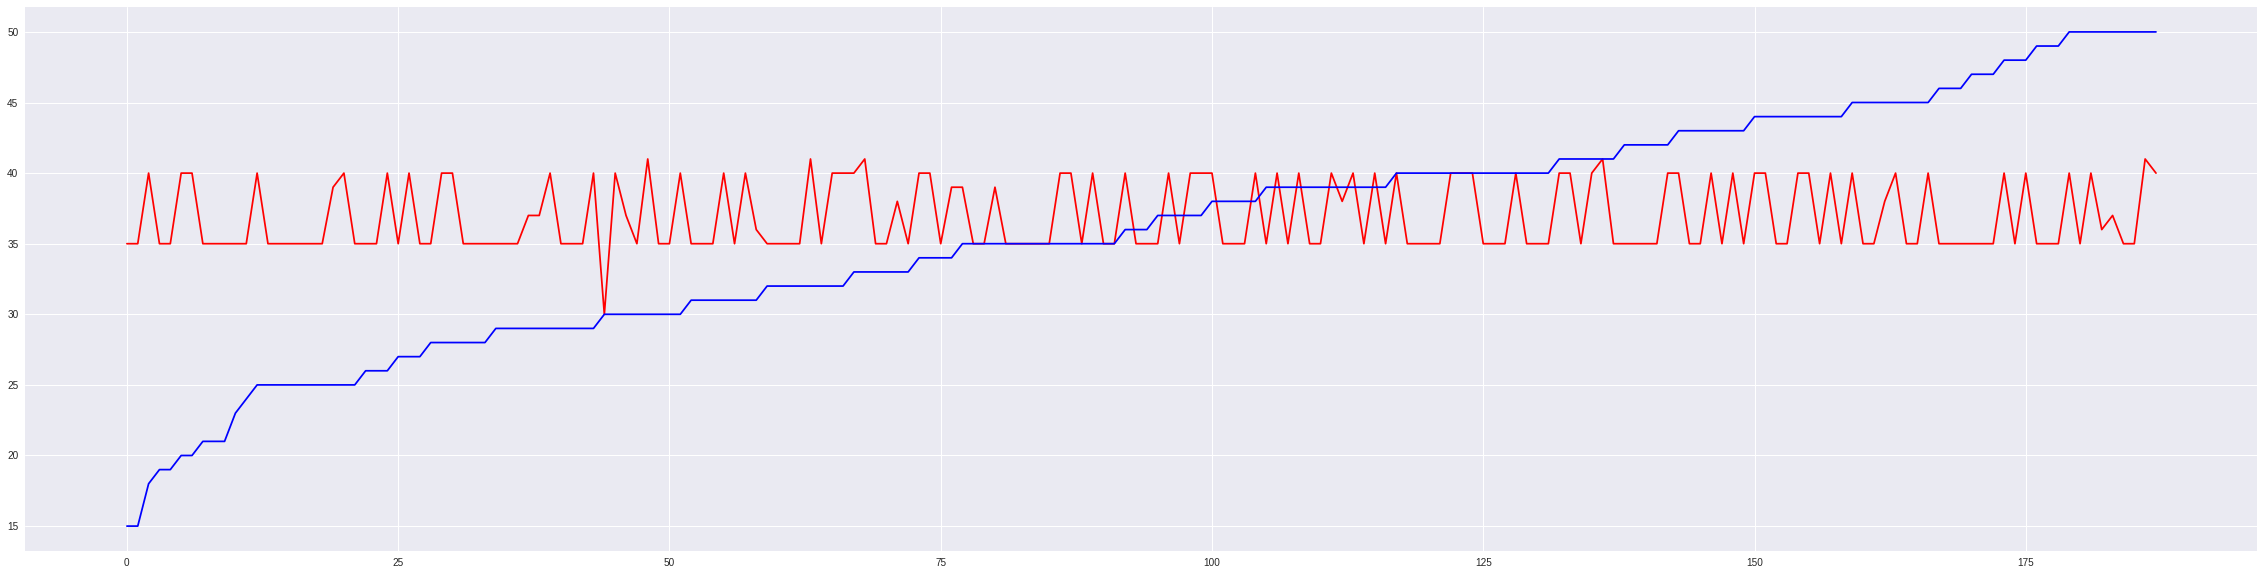

In [20]:
from numpy import *
import math
import matplotlib.pyplot as plt

xs = range(pred_num)

plt.figure(figsize=(40,10))
plt.plot(xs, sorted_preds, 'r') # plotting t, a separately 
plt.plot(xs, sorted_labels, 'b') # plotting t, b separately 
plt.show()

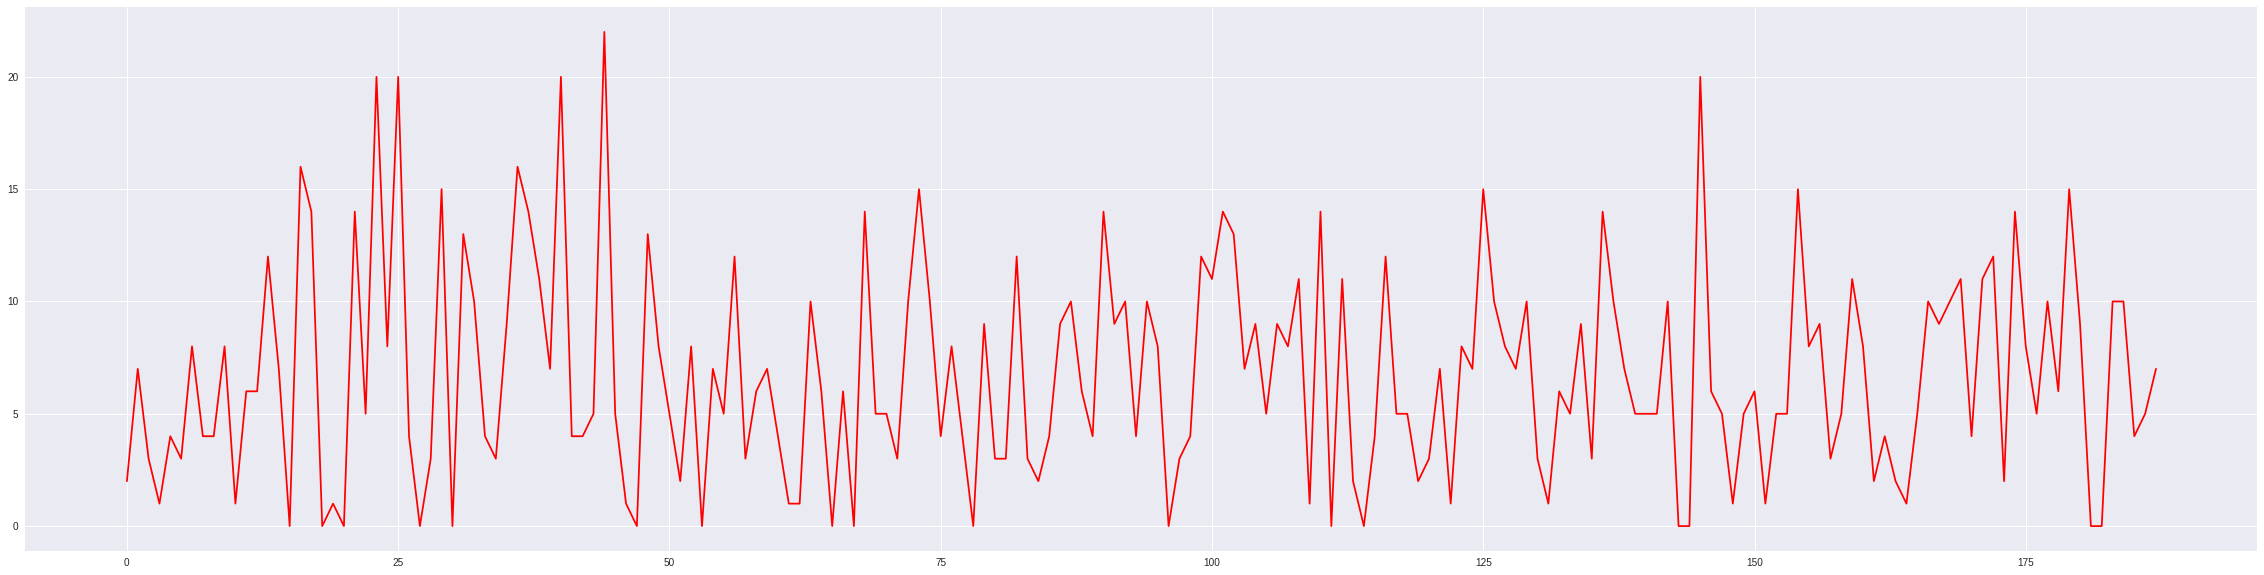

In [15]:
plt.figure(figsize=(40,10))
plt.plot(xs, error_data, 'r') # plotting t, b separately 
plt.show()